# Part    3    ‑    Predictive     modeling    <br>
Ultimate     is     interested     in     predicting     rider     retention.    To    help    explore     this    question,    we    have  provided     a     sample    dataset     of     a     cohort    of    users    who     signed    up     for    an    Ultimate    account     in 
January    2014.    The     data    was    pulled     several    months     later;    we     consider    a    user     retained     if     they  were     “active”     (i.e.     took    a     trip)     in     the     preceding    30    days.<br>    We     would     like     you     to    use     this    data     set     to    help    understand    what     factors    are     the    best    predictors  for     retention,    and    offer     suggestions     to     operationalize     those     insights     to    help    Ultimate. <br>   The    data     is     in     the    attached     file     ultimate_data_challenge.json.    See    below     for    a    detailed  description     of     the    dataset.     Please     include    any     code     you    wrote     for     the    analysis    and    delete     the  dataset    when     you    have     finished     with     the     challenge.   <br>
1. Perform    any     cleaning,     exploratory    analysis,    and/or     visualizations     to    use     the    provided  data     for     this    analysis     (a     few     sentences/plots    describing     your    approach    will     suffice).    What  fraction     of     the    observed     users    were     retained?  
2. Build    a    predictive     model     to     help    Ultimate    determine    whether    or    not    a    user    will    be    active  in     their    6th    month     on     the     system.    Discuss    why     you     chose     your    approach,    what  alternatives     you     considered,     and    any     concerns     you    have.    How     valid     is     your    model?  Include    any     key     indicators    of     model    performance.  
3. Briefly    discuss    how     Ultimate     might     leverage     the     insights    gained     from     the    model     to  improve     its     long­  term     rider     retention     (again,    a     few     sentences    will     suffice).

Data    description  
● city:       city     this    user     signed     up     in  
● phone:      primary    device     for     this    user  
● signup_date:      date     of     account     registration;     in     the     form     ‘YYYY MM DD’  
● last_trip_date:       the     last     time     this    user     completed    a     trip;     in     the     form     ‘YYYY MM DD’  
● avg_dist:       the    average     distance     in    miles    per     trip     taken     in     the     first    30    days    after     signup  
● avg_rating_by_driver:       the     rider’s    average     rating    over    all    of     their     trips  
● avg_rating_of_driver:       the     rider’s    average     rating    of     their    drivers    over    all    of     their     trips  
● surge_pct:       the    percent     of     trips     taken    with     surge    multiplier    >    1  
● avg_surge:       The    average     surge    multiplier    over    all    of     this    user’s     trips  
● trips_in_first_30_days:       the     number    of     trips     this    user     took     in     the     first    30    days    after  signing    up   
● ultimate_black_user:       TRUE     if     the    user     took    an    Ultimate    Black     in     their     first    30    days;  FALSE    otherwise  
● weekday_pct:       the     percent     of     the    user’s     trips    occurring    during    a    weekday    

In [38]:
# Import data using pandas read_json
# Import pandas library
import pandas as pd

# Read data from json file
df = pd.read_json("ultimate_data_challenge.json", orient='records')

# Check the dataframe
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


The first thing to note: the JSON file presents missing data with NaN. The method pd.read_json failed, so I replaced NaN with null.<br> I now need to deal with the missing data. Let's check how many we have per column

In [39]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

## Missing values
We can observe that the column avg_rating_of_driver has 8122 missing values and avg_rating_by_driver has 201, which is unfortunate. My intuition says that rider's retention and how they rate their drivers may have an association, so dropping all these values is out of question.<br>
With that in mind, for the two columns with ratings, I'll replace it with the mean value of the column. For the column "phone", I'll simply replace it by the mode.   

In [40]:
# Import libraries
import numpy as np
from scipy import stats

# Calculate averages for the two rating columns
avg_of_driver = np.round(np.mean(df.avg_rating_of_driver),decimals = 1)
avg_by_driver = np.round(np.mean(df.avg_rating_by_driver),decimals = 1)

# Calculate mode for the phone column
mode_phone = stats.mode(df.phone[df.phone.notnull()])

# Check the results
print(avg_of_driver,avg_by_driver,mode_phone[0])

4.6 4.8 ['iPhone']


In [41]:
# Prepare a dictionary with the columns to replace and the values to replace with
values = {'avg_rating_of_driver': avg_of_driver, 'avg_rating_by_driver': avg_by_driver, 'phone': 'iPhone'}

# Fill na values
df.fillna(value=values, inplace=True)

In [42]:
# Check for NaNs
df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [43]:
# Check the unique values of the phone column, to see if there's only iPhone and Android
df.phone.unique()

array(['iPhone', 'Android'], dtype=object)

## Analysing the retention
<b>What fraction of the observed users were retained?</b>
Analyzing the retention rate <u>over time</u> will allow me to answer this question and more. First, I'll check the data type of the columns signup_date and last_trip_date.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Two columns have dates stored as string. I want to do date operations, so let's convert it to datetime

In [45]:
# Import datetime library. timedelta will be used later
from datetime import datetime, timedelta

# Apply conversion for every element of the two columns
df.signup_date  = df.signup_date.apply(lambda x:datetime.strptime(x,"%Y-%m-%d"))
df.last_trip_date = df.last_trip_date.apply(lambda x:datetime.strptime(x,"%Y-%m-%d"))

# Check datatypes for the two columns
df.info()

# PS: running this cell twice will throw an error

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Now, let's create a column with the difference, in days, between the last trip and the signup date. 

In [46]:
# The difference between two datetime objects is a timedelta object
df["diff_days"] = df.last_trip_date - df.signup_date

# I just want the number of days as an integer, so I'll just use the property .days from the timedelta objects
df.diff_days = df.diff_days.apply(lambda x:x.days)

# Validate the operation
df.diff_days

0        143
1         96
2          1
3        170
4         47
        ... 
49995    131
49996      1
49997    111
49998      1
49999     92
Name: diff_days, Length: 50000, dtype: int64

The operation was successful. Let's prepare the plot, remembering that a user is considered active if they took a trip in the last 30 days.

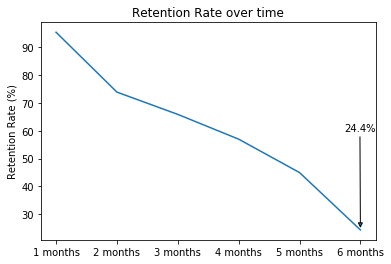

In [47]:
# Import library
import matplotlib.pyplot as plt

# List to record the retention rates
rr = []

# Range of days to be considered
days_range = np.arange(30,210,30)

# Loop though the days_range
for day in days_range:
    # append the proportion of users active after "day" amount of days. Notice the + 30 to consider the active period
    rr.append(np.round((len(df.diff_days[df.diff_days + 30 > day])/len(df))*100, decimals=1))
    
# Prepare the plot
plt.plot(days_range, rr)

# Y axis label
plt.ylabel("Retention Rate (%)")

# Plot title
plt.title("Retention Rate over time")

# Changing the tick marks of X axis, to look better
plt.xticks(days_range, [str(x+1) + " months" for x in (range(6))])

# Annotate the desired value: retention after 6 months
plt.annotate(s = str(rr[5]) + "%", xy=(180,rr[5]), xytext=(172,60), arrowprops = {'arrowstyle':'-|>'})

# Show plot
plt.show()


- <b>The Retention Rate after 6 months, for this January cohort, is 24.4%</b><br>
- We need more data to see if the rate reaches a plateau after more months because the retention rate is still dropping linearly<br><br>
On to the next item:<br>
# Predicting models
<b>2.Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.</b><br><br>
Few considerations:
- I am building a model for a random user <b>1 month after signup</b>. I need at least a month to have data on the user, like "trips_in_first_30_days", ratings, etc.
- That user signed up on a date that is not in the range considered in the column "signup_date" because I am trying to predict the future. Besides, the model needs to predict active users in their 6th month regardless of their signup_date. As a consequence, <b>"signup_date" will be dropped</b>.
- The column "last_trip_date" is based on 6 months after the signup_date. This model will run only 1 month after the signup date, so we won't have this column when applying the model. With that in mind, <b>"last_trip_date" will also be dropped</b>.
- <b>The column "diff_days" will be dropped</b> because it is the difference between the two columns I am dropping.
<br><br>Those columns will be dropped right after I define the target column because I need "diff_days" to define it.

## Metrics to evaluate the model
Considering the business, this problem should be rephrased as follows:<br><br>
"Build a predictive model to determine if a user will <b>NOT</b> be active in six months".<br><br>
I am interested in identifying who is likely to abandon Ultimate within 6 months, so we can act on them, giving discounts, special offers, etc.<br>
Now, getting back to the Data Science department, my positive class (flag = 1) will be the users that are inactive within six months. I want to have a <b>high recall rate for the "1" class</b>.I am willing to have some false positives, as long as I have a high "hit rate", meaning that I identify most of the users likely to stop using Ultimate's services within 6 months.<br><br>
With that in mind, let's define our "target" column following this logic:
- 1 if "diff_days" <= 150.
- 0 otherwise
Note that 6 months = 180 days. considering the 30 days that a user can still be considered active without taking trips, we deduct 30 from 180.

In [48]:
# The target colum is a flag: 1 if the user is likely to abandon Ultimate within 6 months, 0 otherwise
df["target"] = df.diff_days.apply(lambda x:1 if x<=150 else 0)

# Check the operation by calculating the proportion of 0's, which should be 24.4%
print(np.round(100-(df.target.sum()/len(df)*100), decimals=1), "%")

24.4 %


Proportion of 0's is matching the 24.4% retention rate we found earlier. Let's drop the three columns mentioned in the initial considerations.

In [49]:
# Drop columns we won't have in "real life"
df = df.drop(labels=["signup_date", "last_trip_date", "diff_days"], axis=1)
df

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,target
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,1
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,0
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,1
...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,5.0,1.00,iPhone,0.0,False,100.0,5.63,4.2,1
49996,Astapor,1,4.6,1.00,iPhone,0.0,False,0.0,0.00,4.0,1
49997,Winterfell,0,5.0,1.00,Android,0.0,True,100.0,3.86,5.0,1
49998,Astapor,2,3.0,1.00,iPhone,0.0,False,100.0,4.58,3.5,1


Now let's check which variables correlate with the target column. I'll use the seaborn correlation heatmap to do so.

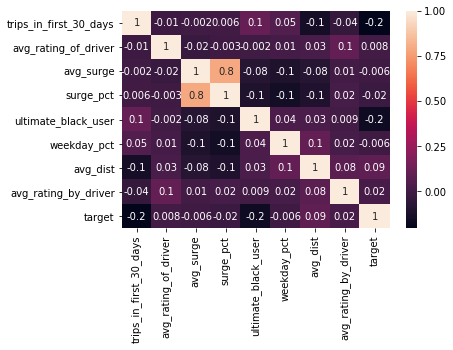

In [50]:
# Import seaborn library
import seaborn as sns

# Build heatmap
sns.heatmap(df.corr(), annot = True, fmt='.1g')

# Show plot
plt.show()

<b>"trips_in_first_30_days" and "ultimate_black_user"</b> have a significant negative correlation with the target column, whereas <b>"avg_dist"</b> has a positive correlation. I also want to test the model using only those three columns.<br><br>
This is a <b>classification problem</b>, and here is my strategy:
- Define a function to plot relevant metrics (printMetrics) according to what was discussed earlier
- Split the data into training (70%) and testing (30%)
- Define a Benchmark --> dummy classifier from sklearn
- Generate dummy variables for the categorical columns --> pd.get_dummies()
- Run a logistic regression two times, one with all variables and another one with only the 3 most correlated
- Compare the performances.<br><br>
If the performance is poor, I'll test another classification model.

In [51]:
# PRINT METRICS FUNCTION DEFINITION

# Import necessary Libraries
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Function that prints the relevant data about a classification model
def printMetrics(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print("Total PREDICTED inactive users within 6 months: ",sum(y_pred))
    print("Total ACTUAL inactive users within 6 months: ", sum(y_test))
    print("R Squared: ", accuracy_score(y_test, y_pred))
    print("F1Score: ", f1_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:")
    print(cm)
    print("Recall: ", cm[1,1]/(cm[1,0]+cm[1,1]))

In [52]:
# SPLIT INTO TRAIN / TEST DATASETS AND DUMMY COLUMNS

# Import necessary Libraries
from sklearn.model_selection import train_test_split

# Isolate the target column
y = df.target

# Drop the target column and store in a copy of the dataFrame df.
df_copy = df.drop(labels="target", axis=1)

# Generate dummy columns for the categorical columns
df_copy = pd.get_dummies(df_copy)

# Split the data: 30% / 70%, full dataset (note the stratify parameter, as the classes are imbalanced)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(df_copy, y, test_size=0.30, random_state=0, stratify=y, shuffle=True)

# Drop all columns except "trips_in_first_30_days", "ultimate_black_user" and "avg_dist"
df_copy = df.drop(labels=[col for col in df.columns if col not in ["trips_in_first_30_days" , "ultimate_black_user", "avg_dist"]], axis=1)

# Split the data: 30% / 70%, slim dataset
X_train_slim, X_test_slim, y_train_slim, y_test_slim = train_test_split(df_copy, y, test_size=0.30, random_state=42, stratify=y, shuffle=True)

In [53]:
# DEFINING BENCHMARK - DUMMY CLASSIFIER

# Import necessary Libraries
from sklearn.dummy import DummyClassifier

# Define and fit dummy classifier
dummy_clf_full = DummyClassifier(random_state=0).fit(X_train_full, y_train_full)

# Print relevant metrics using the full dataset
printMetrics(dummy_clf_full, X_test_full, y_test_full)

Total PREDICTED inactive users within 6 months:  11376
Total ACTUAL inactive users within 6 months:  11341
R Squared:  0.6292666666666666
F1Score:  0.7552053528194744
Confusion matrix:
[[ 861 2798]
 [2763 8578]]
Recall:  0.7563706904153072


For the dummy model, the two dataset renders the same metrics. Let's see if we can beat those metrics with a classical Logistic Regression.

In [54]:
# LOGISTIC REGRESSION

# Import LogisticRegression model
from sklearn.linear_model import LogisticRegression

# Train model with full dataset
clf = LogisticRegression(random_state=5, solver= 'lbfgs', max_iter=300).fit(X_train_full, y_train_full)

# Print relevant metrics
printMetrics(clf,X_test_full, y_test_full)

# Same thing for slim dataset (only 3 most correlated columns)
clf = LogisticRegression(random_state=5, solver= 'lbfgs', max_iter=300).fit(X_train_slim, y_train_slim)
printMetrics(clf,X_test_slim, y_test_slim)

Total PREDICTED inactive users within 6 months:  13807
Total ACTUAL inactive users within 6 months:  11341
R Squared:  0.768
F1Score:  0.8616192142516303
Confusion matrix:
[[  686  2973]
 [  507 10834]]
Recall:  0.9552949475354907
Total PREDICTED inactive users within 6 months:  14533
Total ACTUAL inactive users within 6 months:  11341
R Squared:  0.7625333333333333
F1Score:  0.8623328437814022
Confusion matrix:
[[  282  3377]
 [  185 11156]]
Recall:  0.9836875055109778


## Logistic Regression analysis
- Both runs of the model beat all Benchmark metrics
- The Slimmer version of the dataset performed better
- A recall rate of 98% is excellent: the model failed to identify only 185 out of 11,341 users that were likely to become inactive.
- Considering that Ultimate would run marketing campaigns on the positive class, 3,377 users that were likely to be active in six months would benefit from those campaigns. 3,377 discounts for users that don't need discounts! Not the end of the world, but let's see if we can reduce this number.
<br><br>
Let's try the Stochastic Gradient Descent Classifier model.

In [55]:
# STOCHASTIC GRADIENT DESCENT

# Import SGD classifier, along with StandardScaler and make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Train the model with the full dataset. Notice the parameter Class_weight, to consider imbalanced dataset.
# It is highly indicated to use Standard Scaler with this model. A pipeline is required
clf = make_pipeline(StandardScaler(), SGDClassifier(class_weight='balanced', random_state=42)).fit(X_train_full, y_train_full)
printMetrics(clf, X_test_full, y_test_full)

# Slim dataset
clf = make_pipeline(StandardScaler(), SGDClassifier(class_weight='balanced', random_state=42)).fit(X_train_slim, y_train_slim)
printMetrics(clf, X_test_slim, y_test_slim)

Total PREDICTED inactive users within 6 months:  9100
Total ACTUAL inactive users within 6 months:  11341
R Squared:  0.663
F1Score:  0.7527029010322392
Confusion matrix:
[[2252 1407]
 [3648 7693]]
Recall:  0.6783352438056609
Total PREDICTED inactive users within 6 months:  9336
Total ACTUAL inactive users within 6 months:  11341
R Squared:  0.6398
F1Score:  0.7386951685447598
Confusion matrix:
[[1960 1699]
 [3704 7637]]
Recall:  0.673397407636011


## SGD classifier analysis
- All metrics performed worst than the Logistic Regression
- Less false positives (1699) but the price is too high: failed to identify 33% of the positive class
- full dataset performed better than the slimmer version of the dataset
<br><br>
Logistic Regression stands as the best model. I will try one more model, than tweak the best one. Let's try Gradient Booster Classifier.

In [56]:
# GRADIENT BOOSTING CLASSIFIER

# Import Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Train model - full dataset
clf = GradientBoostingClassifier(random_state=42).fit(X_train_full, y_train_full)

# Print metrics
printMetrics(clf, X_test_full, y_test_full)

# Train model - slim dataset
clf = GradientBoostingClassifier(random_state=42).fit(X_train_slim, y_train_slim)

# Print metrics
printMetrics(clf, X_test_slim, y_test_slim)


Total PREDICTED inactive users within 6 months:  12710
Total ACTUAL inactive users within 6 months:  11341
R Squared:  0.8026
F1Score:  0.876886615941125
Confusion matrix:
[[ 1494  2165]
 [  796 10545]]
Recall:  0.9298121858742615
Total PREDICTED inactive users within 6 months:  14070
Total ACTUAL inactive users within 6 months:  11341
R Squared:  0.7638
F1Score:  0.860572193144701
Confusion matrix:
[[  523  3136]
 [  407 10934]]
Recall:  0.9641125121241513


## Gradient Boosting Classifier analysis
- The slim dataset has a better Recall Rate, but worse R squared and F1 score, compared to the full dataset
- Considering the slim dataset, all metrics performance were close to the Logistic Regression metric's performance.
- As mentioned earlier, the Recall rate is very important, so I'll stick with the Logistic Regression - Slim dataset (98% > 96%)
<br><br>

## Logistic Regression tweaking
Logistic Regression, with the slim dataset, is the best model. Let's try <b>tweaking some parameters</b> to see if we can improve the score. For that, I'll use gridSearchCV.

In [59]:
# TWEAKING LOGISTIC REGRESSION PARAMETERS - SOLVER

from sklearn.model_selection import GridSearchCV

parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
cl = LogisticRegression(random_state=42, max_iter=300)
clf = GridSearchCV(cl, parameters, cv=3).fit(X_train_slim, y_train_slim)

print(clf.best_params_)

# Print metrics
printMetrics(clf, X_test_slim, y_test_slim)

{'solver': 'liblinear'}
Total PREDICTED inactive users within 6 months:  14533
Total ACTUAL inactive users within 6 months:  11341
R Squared:  0.7625333333333333
F1Score:  0.8623328437814022
Confusion matrix:
[[  282  3377]
 [  185 11156]]
Recall:  0.9836875055109778


The best solver chosen by grid search was 'liblinear', but the performance is the same as with solver='lbfgs'.<br>
I am now tweaking the <b>penalty</b>. The reason I did not tweak the Solver and the Penalty together is because not all solvers accept all penalties. With that in mind, I'll use solver='liblinear, to try penalties L1 and L2. ('lbfgs' does not support L1 penalty).

In [60]:
# TWEAKING LOGISTIC REGRESSION PARAMETERS - PENALTY

from sklearn.model_selection import GridSearchCV

parameters = {'penalty':('l1', 'l2')}
cl = LogisticRegression(random_state=42, max_iter=300, solver='liblinear')
clf = GridSearchCV(cl, parameters, cv=3).fit(X_train_slim, y_train_slim)

print(clf.best_params_)

# Print metrics
printMetrics(clf, X_test_slim, y_test_slim)

{'penalty': 'l1'}
Total PREDICTED inactive users within 6 months:  14533
Total ACTUAL inactive users within 6 months:  11341
R Squared:  0.7625333333333333
F1Score:  0.8623328437814022
Confusion matrix:
[[  282  3377]
 [  185 11156]]
Recall:  0.9836875055109778


GridSearch chose L1 penalty, but the performance is the same. Lastly, I'll tweak the <b>regularization strength C</b>.

In [63]:
# TWEAKING LOGISTIC REGRESSION PARAMETERS - C

from sklearn.model_selection import GridSearchCV

parameters = {'C':(0.01, 0.1, 1)}
cl = LogisticRegression(random_state=42, max_iter=300, solver='liblinear')
clf = GridSearchCV(cl, parameters, cv=3).fit(X_train_slim, y_train_slim)

print(clf.best_params_)

# Print metrics
printMetrics(clf, X_test_slim, y_test_slim)

{'C': 0.1}
Total PREDICTED inactive users within 6 months:  14535
Total ACTUAL inactive users within 6 months:  11341
R Squared:  0.7625333333333333
F1Score:  0.862343484309785
Confusion matrix:
[[  281  3378]
 [  184 11157]]
Recall:  0.9837756811568644


C=0.1 was chosen as the best, and the differences are 1 more false positive and 1 less false negative. Virtually the same, I'll just stick to the original model.<br><br>
Using the best model, let's check the <b>coeficients</b> for each of the three columns, to see which one is more important:

In [65]:
# Train the best model
clf = LogisticRegression(random_state=5, solver= 'lbfgs', max_iter=300).fit(X_train_slim, y_train_slim)

# Print coefficients
print(clf.coef_)

# Print variables
print(df_copy.columns)

[[-0.10392932 -0.68687979  0.03532109]]
Index(['trips_in_first_30_days', 'ultimate_black_user', 'avg_dist'], dtype='object')


# Insights from the model
We notice that being an <b>ultimate black user</b> is the most relevant feature: those users are more prone to be active after 6 months. The second most important is the number of trips the user made on the first 30 days.<br>
Here are the concrete actions I would recommend:
- Among the users I predicted as likely to abandon ultimate within 6 months, identify those who are ultimate black and offer them something nice, like a discount free rides. Technically speaking, to find those users, it suffices to run the model for the actual dataset, create a column with the predictions, then filter "predictions = 1" and "ultimate_black_user = 1".
- For the users "predictions = 1" and "ultimate_black_user = 0", offer them the ultimate black service at no additional cost. Let them feel the comfort!
- Lastly, I'd act on the number of trips in the first 30 days. Free rides for new users could help them try to "insert" the Ultimate services in their routine.